In [1]:
# Preamble
from astropy.table import Table, column, vstack
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

In [3]:
# load the data
ml_data = Table.read('ml_table_matched.fits')
gz2_data = Table.read('.././fits/full_sample_debiased_w_low_z_mod.fits')

In [4]:
def get_gz2_stats(gz2_data,tabulate=True):
    m_colnames = ['t11_arms_number_a31_1_debiased_rh',
                  't11_arms_number_a32_2_debiased_rh',
                  't11_arms_number_a33_3_debiased_rh',
                  't11_arms_number_a34_4_debiased_rh',
                  't11_arms_number_a36_more_than_4_debiased_rh']
    
    w_colnames = ['t10_arms_winding_a28_tight_debiased_rh',
                  't10_arms_winding_a29_medium_debiased_rh',
                  't10_arms_winding_a30_loose_debiased_rh']
    
    m_array = np.array([gz2_data[column] for column in m_colnames]).T
    w_array = np.array([gz2_data[column] for column in w_colnames]).T
    m = np.argmax(m_array,axis=1) + 1
    w = np.argmax(w_array,axis=1) + 1
    m_max = np.max(m_array,axis=1)
    w_max = np.max(w_array,axis=1)
    def measure_wtd_avg(array):
        N_rows, N_columns = np.shape(array)
        wtd_avg = np.zeros(N_rows)
        for c in range(N_columns):
            wtd_avg += array[:,c]*(c+1)
        wtd_avg_sum  = np.sum(array,axis=1)
        return wtd_avg/wtd_avg_sum
    m_wtd_avg = measure_wtd_avg(m_array)
    w_wtd_avg = measure_wtd_avg(w_array)
    p_bar = gz2_data['t03_bar_a06_bar_debiased_rh']
    if tabulate is True:
        table = Table(np.array([m,w,m_max,w_max,m_wtd_avg,w_wtd_avg,p_bar]).T,
            names=('m','w','m_max','w_max','m_wtd_avg','w_wtd_avg','p_bar'))
        return table
    else:
        return m, w, m_max, w_max ,m_wtd_avg, w_wtd_avg, p_bar

In [37]:
in_ml_sample = ml_data['redshift_error_ok']
print('{} ML-spirals in the Vmax-limited sample!'.format(in_ml_sample.sum()))

7062 ML-spirals in the Vmax-limited sample!


In [8]:
ml_gz2_stats = get_gz2_stats(gz2_data[in_ml_sample])

bar_bins = np.ones(len(ml_gz2_stats))
bar_bins[ml_gz2_stats['p_bar'] < 0.5] = 2
bar_bins[ml_gz2_stats['p_bar'] < 0.2] = 3
ml_gz2_stats['bar_bin'] = bar_bins

ml_stats = ml_data[in_ml_sample]

In [9]:
def weighted_percentile(data, percents, weights=None):
    ''' percents in units of 1%
    weights specifies the frequency (count) of data.
    '''
    if weights is None:
        return np.percentile(data, percents)
    ind=np.argsort(data)
    d=data[ind]
    w=weights[ind]
    p=1.*w.cumsum()/w.sum()*100
    y=np.interp(percents, p, d)
    return y

In [10]:
sample_stats = Table()

mlabels = ('1','2','3','4','5+')

blabels = ('(\mathrm{all})','(p_\mathrm{bar} < 0.5)','(p_\mathrm{bar} < 0.2)')

sample_strings = []
N_gals = []
mass_percentiles = []
mass_list = []

for b in range(3):
    in_bar_bin = ml_gz2_stats['bar_bin'] >= b+1
    for m in range(5):
        in_m_bin = ml_gz2_stats['m'] == m+1
        sample_strings.append('$m={} \, {}$'.format(mlabels[m],blabels[b]))
        
        in_mbar = np.all([in_bar_bin,in_m_bin],axis=0)
        N_gals.append(in_mbar.sum())
        
        masses_mb = ml_stats['mass'][in_mbar]
        weights_mb = ml_stats['vmax_weight'][in_mbar]
        percentiles_mb = weighted_percentile(masses_mb,(5,25,50,75,95),
                                             weights_mb)
        mass_percentiles.append(percentiles_mb)
        mass_list.append(masses_mb)

sample_stats['sample'] = sample_strings
sample_stats['N_gal'] = N_gals
sample_stats['mass_percentiles'] = mass_percentiles

In [12]:
from match_distributions import match_distributions

reference_masses = mass_list[3]
masks = []

for masses in mass_list:
    mask, _ = match_distributions(masses,reference_masses)
    masks.append(mask)

In [13]:
N_gals = []
mass_percentiles = []

i = 0

for b in range(3):
    in_bar_bin = ml_gz2_stats['bar_bin'] >= b+1
    for m in range(5):
        in_m_bin = ml_gz2_stats['m'] == m+1
        in_mbar = np.all([in_bar_bin,in_m_bin],axis=0)
        
        mass_matched = masks[i]
        N_gals.append(mass_matched.sum())
        masses_mbm = ml_stats['mass'][in_mbar][mass_matched]
        weights_mbm = ml_stats['vmax_weight'][in_mbar][mass_matched]
        percentiles_mbm = weighted_percentile(masses_mbm,(5,25,50,75,95),
                                             weights_mbm)
        mass_percentiles.append(percentiles_mbm)
        mass_list.append(masses_mbm)
        i = i+1
        
sample_stats['N_gal_matched'] = N_gals
sample_stats['mass_percentiles_matched'] = mass_percentiles

In [14]:
def custom_boxplot(ax,medians,boxes,whiskers,**kwargs):
    N_boxes = len(medians)
    arbitrary_data = [np.random.randn(100) for n in range(N_boxes)]
    bp = ax.boxplot(arbitrary_data,**kwargs)
    for n in range(N_boxes):
        bp['medians'][n].set_ydata(medians[n])
        bp['boxes'][n].set_ydata([boxes[0][n],boxes[0][n],
                                  boxes[1][n],boxes[1][n],
                                  boxes[0][n]])
        bp['whiskers'][2*n].set_ydata([boxes[0][n],whiskers[0][n]])
        bp['whiskers'][2*n+1].set_ydata([boxes[1][n],whiskers[1][n]])
        bp['caps'][2*n].set_ydata(whiskers[0][n])
        bp['caps'][2*n+1].set_ydata(whiskers[1][n])
    return None

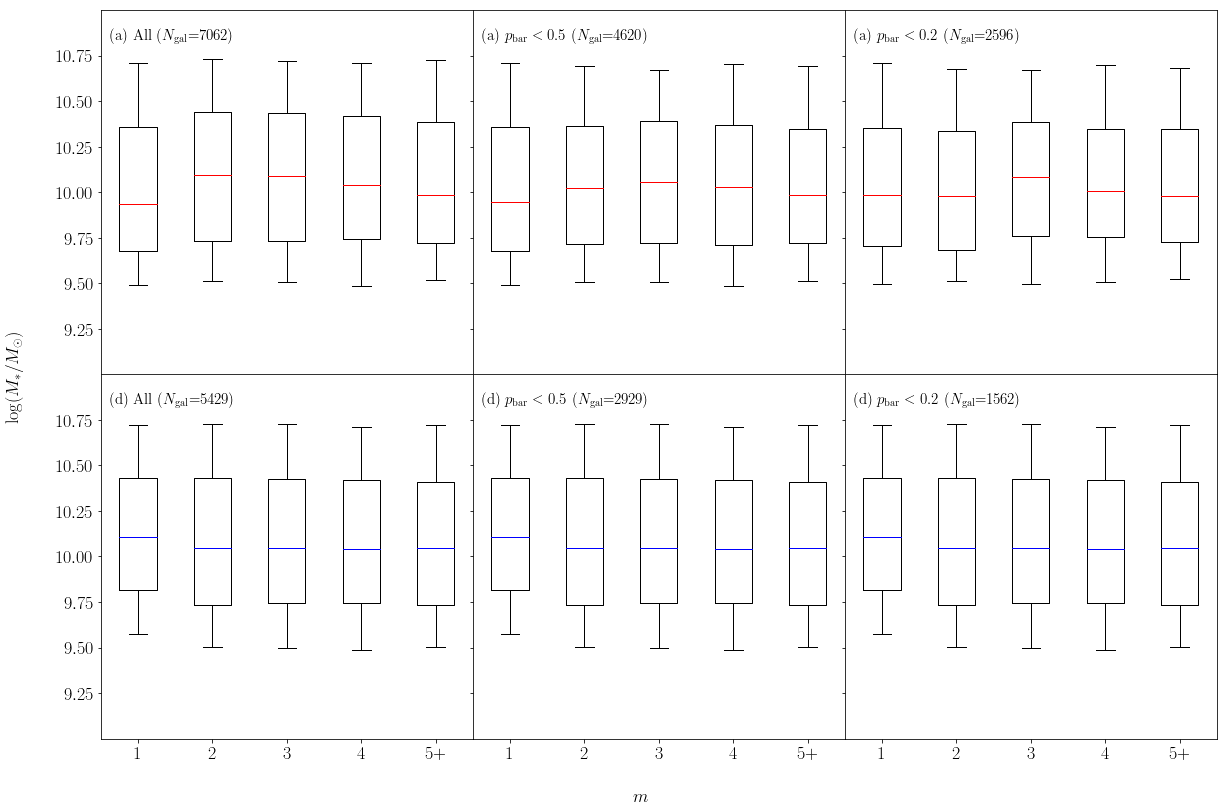

In [15]:
fig, axarr = plt.subplots(2,3,figsize=(20,13.4),
                          sharex=True,sharey=True)

def percentile_box_plotter(axarr,table,letters='ad',label='All'):
    N = len(table)
    ax = axarr[0]
    mass_percentiles = table['mass_percentiles']
    medians = [mass_percentiles[i][2] for i in range(N)]
    boxes = [[mass_percentiles[i][1] for i in range(N)],
             [mass_percentiles[i][3] for i in range(N)]]
    whiskers = [[mass_percentiles[i][0] for i in range(N)],
                 [mass_percentiles[i][4] for i in range(N)]]

    _ = custom_boxplot(ax,medians,boxes,whiskers,showfliers=False,
                       medianprops={'color':'r'})

    ax = axarr[1]
    mass_percentiles = sample_stats['mass_percentiles_matched']
    medians = [mass_percentiles[i][2] for i in range(N)]
    boxes = [[mass_percentiles[i][1] for i in range(N)],
             [mass_percentiles[i][3] for i in range(N)]]
    whiskers = [[mass_percentiles[i][0] for i in range(N)],
                [mass_percentiles[i][4] for i in range(N)]]

    _ = custom_boxplot(ax,medians,boxes,whiskers,showfliers=False,
                       medianprops={'color':'b'})
    
    _ = axarr[0].text(0.025,0.95,
      '({}) {} ($N_\mathrm{{gal}}$={})'.format(letters[0],label,
                                            table['N_gal'].sum()),
                  transform=axarr[0].transAxes,ha='left',va='top',
                  fontsize=15)
    
    _ = axarr[1].text(0.025,0.95,
      '({}) {} ($N_\mathrm{{gal}}$={})'.format(letters[1],label,
                                            table['N_gal_matched'].sum()),
                  transform=axarr[1].transAxes,ha='left',va='top',
                  fontsize=15)
    return None

_ = percentile_box_plotter(axarr[:,0],sample_stats[:5],label='All')
_ = percentile_box_plotter(axarr[:,1],sample_stats[5:10],
                           label='$p_\mathrm{bar}<0.5$')
_ = percentile_box_plotter(axarr[:,2],sample_stats[10:],
                           label='$p_\mathrm{bar}<0.2$')

_ = axarr[0,0].set_ylim(9,11)
for ax in axarr[:,-1]:
    _ = ax.set_xticklabels(['1','2','3','4','5+'])

#fig.tight_layout()
fig.subplots_adjust(hspace=0,wspace=0)

_ = fig.text(0.5, 0.06, '$m$', ha='center')
_ = fig.text(0.06, 0.5, '$\log(M_*/M_\odot)$',
             va='center', rotation='vertical')

fig.savefig('mass_distributions.pdf')

In [16]:
for column in ml_gz2_stats.colnames:
    ml_stats[column] = ml_gz2_stats[column]

In [19]:
mass_matched_mask = np.zeros(len(ml_stats))

i = 0

mass_mask_list = [np.zeros(len(ml_stats)),np.zeros(len(ml_stats)),
                  np.zeros(len(ml_stats))]

for b in range(3):
    in_bar_bin = ml_gz2_stats['bar_bin'] >= b+1
    for m in range(5):
        in_m_bin = ml_gz2_stats['m'] == m+1
        mask = masks[i]
        in_mbar_bin = np.all([in_m_bin,in_bar_bin],axis=0)
        mass_mask_list[b][in_mbar_bin] = mask
        i = i+1

In [34]:
for L, mml in enumerate(mass_mask_list):
    ml_stats['mass_matched_{}'.format(L+1)] = np.array(mass_mask_list[L],dtype='bool')
    #ml_stats.remove_column('mass_matched_{}'.format(L))# = mass_mask_list[L]

In [45]:
from combining_catalogues import make_matched_catalogue, match_ids

ids_ = match_ids(gz2_data,ml_stats,'dr7objid','dr7id')
ml_stats_matched = make_matched_catalogue(gz2_data,ml_stats,ids_)

ml_stats_matched['dr7id'] = gz2_data['dr7objid']
ml_stats_matched['dr8id'] = gz2_data['dr8objid']

ml_stats.write('ml_stats.fits',overwrite=True)
ml_stats_matched.write('ml_stats_matched.fits',overwrite=True)

248883 galaxies in the reference catalogue
7062 galaxies in the match catalogue
---> 7062 matches in total
INFO

INFO:astropy:Upgrading Table to masked Table. Use Table.filled() to convert to unmasked table.


: Upgrading Table to masked Table. Use Table.filled() to convert to unmasked table. [astropy.table.table]
